(time-frequency-analysis)=
# Time-Frequency Analysis

In this section we will discuss the representation of signals in time and frequency domain and how it can be useful for analysis.

## Fourier Series Expansion

Let's revisit the sine wave example. It can be represented by its amplitude, frequency, and phase. 


A periodic signal can be decomposed into a sum of sine waves with different amplitudes, frequencies, and phases. For example, below is a decomposition of a square wave.

$$\textrm{square wave} = sin(x) + sin(3x)/3 + sin(5x)/5 + sin(7x)/7 ...$$

![](https://upload.wikimedia.org/wikipedia/commons/b/bd/Sigma-approximation_of_a_Square_Wave_.gif)



Image Source: Wikipedia

The representation can be obtained by calculating the [**Fourier Series**](https://mathworld.wolfram.com/FourierSeries.html) for the function. 

## Fourier Transform

The analogue for this representation for discrete signals can be obtained through the **Discrete Fourier Transform** (DFT), which converts a signal from its **time domain** representation to its **frequency domain** representation. Similar to the above, we can interpret this operation as decomposing the signal into many different frequencies.

In practice, we usually use the Fast Fourier Transform (FFT) algorithm to compute the DFT. Let's look at a couple examples below.

<!-- $$ \mathcal{\hat{f}}[k] = \sum_{n=0}^{N-1}e^{-2\pi j \frac{kn}{N}}f[n] $$
This converts the signal from the time domain to frequency domain. -->

In [1]:
import numpy as np
import scipy as sp
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

In [2]:
# Time base used for all signals in this notebook
N = 1000
end_time = 1
time = np.linspace(0, end_time, end_time*N, endpoint=False) # 1 sec

### Sine wave

For a simple sine wave at 50 Hz, we expect to see just a single peak in the spectrum. However, below we actually see 2 peaks.

What is happening? It turns out that the FFT is symmetric and the maximum positive frequency is half the sampling frequency. This is also the frequency range within which we can accurately reconstruct the signal, based on the [Nyquist-Shannon Sampling Theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem).

In [3]:
# Sine wave
freq = 50
cw = np.sin(2*np.pi*freq*time)

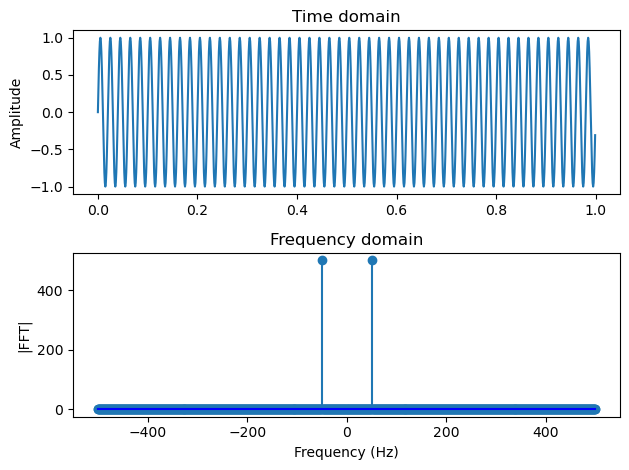

In [4]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(time, cw)
ax1.title.set_text("Time domain")
ax1.set_ylabel("Amplitude")
fig.tight_layout()

ax2.stem(fftfreq(N, 1)*N, np.abs(fft(cw)), basefmt='b-')
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("|FFT|")
ax2.title.set_text("Frequency domain")
fig.tight_layout()

### Chirp

For a chirp signal with frequency sweeping from 1-100 Hz, below we can see that the FFT gives the spectrum showing the frequency content corresponding to this range. Here, only the right half of the symmetric FFT spectrum (the positive frequencies) is plotted.

In [5]:
# Chirp
chirp = sp.signal.chirp(time, f0=1, t1=1, f1=100)

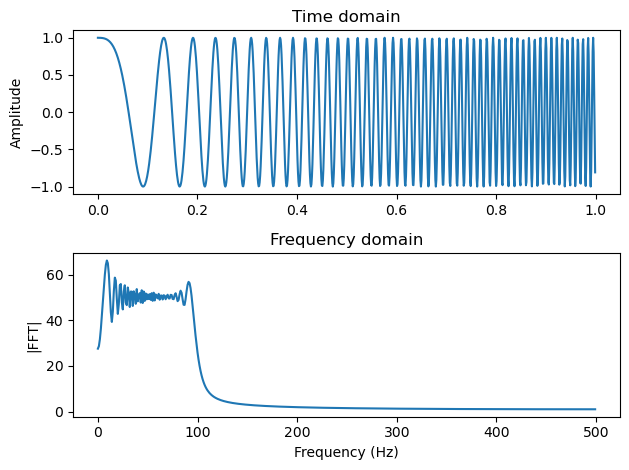

In [6]:
# Chirp FFT
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(time, chirp)
ax1.title.set_text("Time domain")
ax1.set_ylabel("Amplitude")
fig.tight_layout()

ax2.plot(N*fftfreq(N, 1)[:np.round(N//2)], np.abs(fft(chirp))[:(N//2)])#, '.', markerfacecolor='none')
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("|FFT|")
ax2.title.set_text("Frequency domain")
fig.tight_layout()

:::{note}
The oscillatory pattern you see in the spectrum here is due to the sharp change of frequency content, known as the [Gibbs phenomenon](https://en.wikipedia.org/wiki/Gibbs_phenomenon).
:::

## Short-Time Fourier Transform and the spectrogram

The frequency content of a chirp changes over time. This is hard to see in the pure frequency domain representation shown above. To capture the temporally varying frequency content of a signal, we can split the signal into short segments, compute the FFT for each segment, and plot the magnitude spectum against both time and frequency. This operation is referred to as **Short-Term Fourier Transform (STFT)** and the result can be visualized as the **spectrogram**. Note that these segments can be overlapping, which can help capture the transient nature of the signal.

Below we take a look at the spectrogram of a few basic signal types.

### Sine wave

For a simple sine wave, since the frequency is contant, in the spectrogram we can see a horizontal line at 100 Hz.

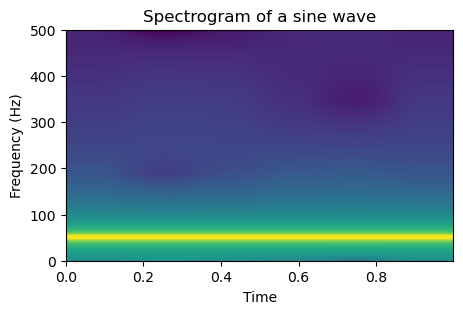

In [7]:
plt.figure(figsize=(5,3))
s, s_freq, s_t, im = plt.specgram(cw, NFFT = 256, Fs = N, xextent=[time[0],time[-1]])
plt.title("Spectrogram of a sine wave")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.show()

### Chirp

For a chirp, rather than only seeing the spectrum of the entire signal, with the spectrogram we can see the gradual rise of frequency across time.

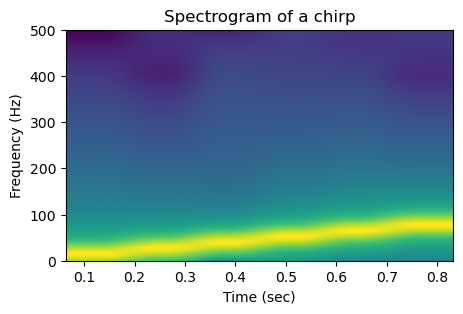

In [8]:
plt.figure(figsize=(5,3))
s, s_freq, s_t, im = plt.specgram(chirp, NFFT=256, Fs=N)
plt.title("Spectrogram of a chirp")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")
plt.show()

:::{caution}
Looking at the linear increase of frequency over time, we can that the line looks smooth but slightly wiggly. This is a result of the automatic interpolation of the plotting function, which can be turned off to correctly interpret the discrete values.
:::

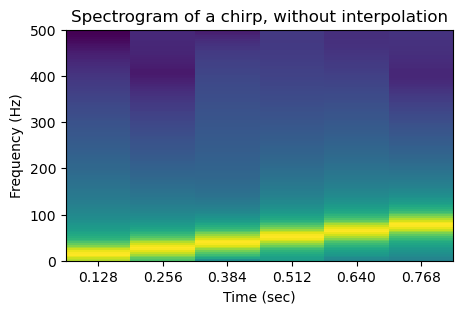

In [9]:
plt.figure(figsize=(5,3))
s, s_freq, s_t, im = plt.specgram(chirp, NFFT=256, Fs=N, interpolation='none', mode='magnitude')
plt.title("Spectrogram of a chirp, without interpolation")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")
out = plt.xticks(s_t)

The `plt.specgram` function has a lot of parameters which are hidden under the hood in the above function call that uses the default values for these parameters. You can see them in the screenshot below from the [matplotlib.pyplot.specgram documentation page](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.specgram.html).

```{image} ../images/signals/specgram_matplotlib.png
:width: 600px
:align: center
```

The key parameters that affect the resolution (in both time and frequency) of the output image are the number of points used to compute the STFT (argument `NFFT`), and whether these intervals overlap (`noverlap`). These together determine the number of time and frequency bins of the resulting spectrogram.

For example, in the above plot, the xticks are located at the center of the segment from which the FFT is computed. The spacing between two consecutive xticks is 128/1000 which corresponds to `NFFT-noverlap)/N`.

:::{caution}
It is crucial to read the function documentation, because the exact implementation and arguments can vary across libraries that have the same method. For example, in addition to `matplotlib`, `scipy` also has the [`sciy.signal.spectrogram`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html) function. As you can see below, the arguments are similar but different!

```{image} ../images/signals/spectrogram_scipy.png
:width: 600px
:align: center
```
:::

We can use the widget below to gain a better understanding of how a spectrogram is created.

In [10]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [11]:
def plot_stft_slice_chirp(t, NFFT=256, noverlap=128):

    fig, ax = plt.subplots(2, 2, figsize=(10, 6))

    ax[0,0].clear()
    ax[0,1].clear()
    ax[1,0].clear()
    ax[1,1].clear()

    # identify time window based on t and NFFT
    win_length = NFFT/N

    # plot raw signal with window
    ax[0,0].plot(time, chirp)

    # plot spectrogram with a verical line
    s, s_freq, s_t, im = ax[1,0].specgram(chirp, NFFT=NFFT, noverlap=noverlap, Fs = N, interpolation='none')
    ax[0,0].axvline(t-win_length/2, color="r")
    ax[0,0].axvline(t+win_length/2, color="r")
    ax[0,0].axvspan(t-win_length/2, t+win_length/2, color='red', alpha=.5)
    ax[0,0].set_ylim((-1.1,1.1))
    ax[0,0].set_xlim((0,1))
    ax[0,0].set_title("Chirp")


    idx = np.where(s_t == t)[0]
    ax[1,0].axvline(t, color='r')
    ax[1,0].set_xlabel("Time (sec)", fontsize=10)
    ax[1,0].set_ylabel("Frequency (Hz)", fontsize=10)
    ax[1,0].set_title("STFT")
    ax[1,0].set_xticks(np.concat(([0],s_t, [1])))
    print(s_t)


    # plot power spectrum of slice
    ax[1,1].plot(s[:,idx]/s.max(), s_freq)
    ax[1,1].set_xlabel("Normalized |FFT|", fontsize=10)
    ax[1,1].set_title("Magnitude spectrum")
    ax[1,1].set_xlim((-0.001, 1))

    # making one axis invisible
    ax[0,1].axis('off')
    plt.show()

In [12]:
NFFT_widget = widgets.SelectionSlider(value=256, options=[256, 512, 1024])
noverlap_widget = widgets.SelectionSlider(value=128, options=[0,32,64,128])

def update_time_slider(change):
    time_widget.options = np.floor((np.arange((N-noverlap_widget.value)/(NFFT_widget.value-noverlap_widget.value)))*(NFFT_widget.value - noverlap_widget.value)+NFFT_widget.value/2)/N

NFFT_widget.observe(update_time_slider, names='value')
noverlap_widget.observe(update_time_slider, names='value')

out = interactive(
    plot_stft_slice_chirp,
    NFFT=NFFT_widget,
    noverlap=noverlap_widget,
    t=widgets.SelectionSlider(options=np.floor((np.arange((N-noverlap_widget.value)/(NFFT_widget.value-noverlap_widget.value)))*(NFFT_widget.value - noverlap_widget.value)+NFFT_widget.value/2)/N))
display(out)

interactive(children=(SelectionSlider(description='t', options=(np.float64(0.128), np.float64(0.256), np.float…

### Impulse

What about the spectrogram for an impulse? It is very interesting and drives home the message of why we should **always read the documentation**!

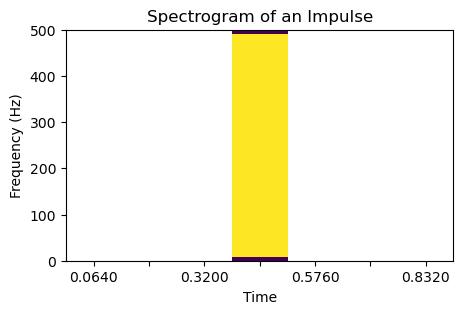

In [13]:
import warnings

impulse = sp.signal.unit_impulse(len(time), round(len(time)/2))
plt.figure(figsize=(5,3))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # hide divided by zero warning
    s, s_freq, s_t, im = plt.specgram(
        impulse, NFFT=128, noverlap=0, Fs=N, interpolation='none'
    )
plt.title("Spectrogram of an Impulse")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.xticks(s_t)

# Only print out every third of the x ticks to avoid overlapping
locs, labels = plt.xticks()
new_labels = [f"{loc:.4f}" if i % 2 == 0 else "" for i, loc in enumerate(locs)]
plt.xticks(locs, new_labels)

plt.show()

:::{caution}
What is going on? By default `plt.specgram` plots on the log scale (in dB). When the value is zero the resulting plot contains NaNs, which are the empty space in the above plot.

To avoid this problem, we can plot on the linear scale by setting `scale='linear'`. We should also check the type of spectrum used. By default the function uses `mode="psd"`, a statistical estimate of the spectrum. We can plot the magnitude of the FFT by using `mode='magnitude"`.
:::

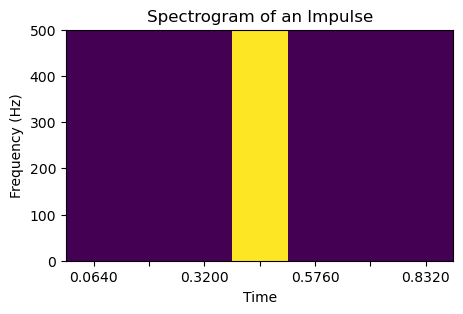

In [14]:
impulse = sp.signal.unit_impulse(len(time), round(len(time)/2))
plt.figure(figsize=(5,3))
s, s_freq, s_t, im = plt.specgram(
    impulse, NFFT=128, noverlap=0, Fs=N, interpolation='none',
    scale='linear', mode='magnitude'
) 
plt.title("Spectrogram of an Impulse")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.xticks(s_t)

# Only print out every third of the x ticks to avoid overlapping
locs, labels = plt.xticks()
new_labels = [f"{loc:.4f}" if i % 2 == 0 else "" for i, loc in enumerate(locs)]
plt.xticks(locs, new_labels)

plt.show()

We see that the spectrogram is positive only at the timestamp of the impulse, and have a frequency content that goes across all frequencies.

### An call from an orca

Now that we have a better understanding of the spectrogram, let's look at one real example: a call of an orca from the [Watkins Marine Mammal Sound Database](https://whoicf2.whoi.edu/science/B/whalesounds/).

In [15]:
# Listening to the call
import IPython
IPython.display.Audio("https://whoicf2.whoi.edu/science/B/whalesounds/WhaleSounds/92301007.wav")

In [16]:
# reading a buzz call
from scipy.io import wavfile
sample_rate, signal = wavfile.read("../resources/watkins_orca_92301007.wav")

In [17]:
N = len(signal)

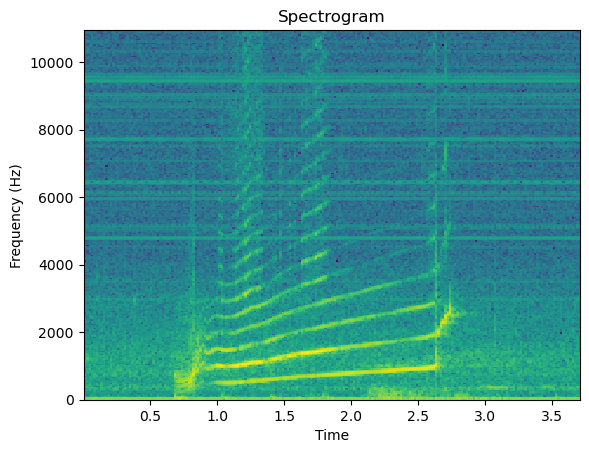

In [18]:
s, s_freq, s_t, im = plt.specgram(signal, NFFT=512, Fs=sample_rate, interpolation='none')
plt.title("Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.show()

We can use the same widget as before to get a better idea of the different temporally transient components of the call, by observing how the spectrum changes with time and how the `NFFT` parameter affects the resolution.

In [26]:
def plot_stft_slice_orca(t, NFFT=256, noverlap=128):

    fig, ax = plt.subplots(2,2, figsize=(10, 6))
    fig.subplots_adjust(hspace=0.3)
    ax[0,0].clear()
    ax[0,1].clear()
    ax[1,0].clear()
    ax[1,1].clear()

    # identify time window based on t and NFFT
    win_length = NFFT/N

    # plot raw signal with window
    ax[0,0].plot(np.linspace(0,len(signal)/sample_rate, len(signal)), signal)

    # plot spectrogram with a verical line
    s, s_freq, s_t, im = ax[1,0].specgram(
        signal, NFFT=NFFT, noverlap=noverlap, Fs=sample_rate, interpolation='none')
    ax[0,0].axvline(t-win_length/2, color="r")
    ax[0,0].axvline(t+win_length/2, color="r")
    ax[0,0].axvspan(t-win_length/2, t+win_length/2, color='red', alpha=.5)
    ax[0,0].set_xlim((0, N/sample_rate))
    ax[0,0].set_title("Signal")

    idx = np.where(s_t == t)[0]
    ax[1,0].axvline(t, color='r')
    ax[1,0].set_xlabel("Time (sec)", fontsize=12)
    ax[1,0].set_ylabel("Frequency (Hz)", fontsize=12)
    ax[1,0].set_title("STFT")
    ax[1,0].set_xlim((0, N/sample_rate))

    # plot power spectrum of slice
    ax[1,1].plot(s[:,idx]/s.max(), s_freq)
    ax[1,1].set_xlabel("Normalized |FFT|", fontsize=12)
    ax[1,1].set_title("Magnitude spectrum")
    ax[1,1].set_xlim((-0.001, 1))
    ax[1,1].set_ylim((0, s_freq.max()))

    # making one axis invisible
    ax[0,1].axis('off')
    plt.show()

In [27]:
NFFT_widget = widgets.SelectionSlider(options=[256, 512, 1024, 2048], value=256)
noverlap_widget = widgets.SelectionSlider(options=[0,32,64,128], value=128)

def update_time_slider_orca(change):
    time_widget.options = np.floor((np.arange((N-noverlap_widget.value)/(NFFT_widget.value-noverlap_widget.value)))*(NFFT_widget.value - noverlap_widget.value)+NFFT_widget.value/2)/N*N/sample_rate

NFFT_widget.observe(update_time_slider_orca, names='value')
noverlap_widget.observe(update_time_slider_orca, names='value')

out = interactive(
    plot_stft_slice_orca,
    NFFT=NFFT_widget,
    noverlap=noverlap_widget,
    t=widgets.SelectionSlider(options=np.floor((np.arange((N-noverlap_widget.value)/(NFFT_widget.value-noverlap_widget.value)))*(NFFT_widget.value - noverlap_widget.value)+NFFT_widget.value/2)/N*N/sample_rate)
)
display(out)

interactive(children=(SelectionSlider(description='t', options=(np.float64(0.005844748858447488), np.float64(0…